# ML: Regression

In this notebook:
* linear regression with lm()
* bulk linear regression with `biglm`
* logistic regression with glm()
* `glmnet` for regularized regression (Ridge, Lasso, Elastic Net)

Note: Since logistic regression predicts a binary outcome, it may be considered a classification algorithm. However, we include it here since it fits well with the other models in this notebook.

In [1]:
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
wine <- readRDS("small_data/wine.RDS")
inpatient <- readRDS("small_data/Medicare_Provider_Charge_Inpatient_DRGALL_FY2014_clean.RDS")

In [3]:
wine %>% head

Alcohol.content,Malic.acid,As,Alcalinity.in.ash,Magnesium,Total.phenols,Flavonoids,Nonflavonoid.phenols,Proanthocyanidins,Color.Intensity,Hue,OD280.OD315,Proline
14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


## Preparatory code

### Split into training/testing

In [4]:
library(caret)

split <- createDataPartition(y=wine$Alcohol.content,
                             p=0.80,
                             list=FALSE)

Loading required package: lattice
Loading required package: ggplot2


In [7]:
train <- wine[split,]
test <- wine[-split,]

## Linear Regression with lm()

In [8]:
lm <- lm(Alcohol.content ~ ., data=train)

In [9]:
# shows significant predictors with asterisks *
# overall fit can be evaluated with (adjusted) R squared
lm %>% summary


Call:
lm(formula = Alcohol.content ~ ., data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.36026 -0.31287 -0.02983  0.35502  1.43627 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)          10.8778073  0.6931783  15.693  < 2e-16 ***
Malic.acid            0.1360978  0.0503886   2.701  0.00783 ** 
As                    0.3075357  0.2490288   1.235  0.21906    
Alcalinity.in.ash    -0.0438369  0.0218397  -2.007  0.04678 *  
Magnesium            -0.0008272  0.0040681  -0.203  0.83919    
Total.phenols         0.0511685  0.1517595   0.337  0.73653    
Flavonoids            0.0224997  0.1250809   0.180  0.85752    
Nonflavonoid.phenols -0.2224677  0.4826780  -0.461  0.64563    
Proanthocyanidins    -0.1389904  0.1126489  -1.234  0.21947    
Color.Intensity       0.1622888  0.0293428   5.531 1.66e-07 ***
Hue                   0.3090791  0.3085783   1.002  0.31837    
OD280.OD315           0.1424259  0.1250396   1.139  0.2567

In [10]:
# make predictions on testing data
test_pred <- predict(lm, test)
test_pred %>% head

1        2        3        4        5        6 
13.04176 13.83844 13.56354 13.70061 13.59988 13.36139

In [11]:
# compute predicted MSE
mean( (test$Alcohol.content-test_pred)**2 )

[1] 0.2562307

## Use biglm() for bulk linear regression
`biglm` creates objects that are considerably smaller:

In [12]:
library(biglm)

Loading required package: DBI


In [13]:
# lm()
inpatient %>%
    group_by(DRG.code) %>%
    do(mod = lm(Average.Total.Payments ~ Total.Discharges , data=.)) %>%
    object.size() %>%
    print(unit = "Mb")

51.3 Mb


In [14]:
# biglm()
inpatient %>%
    group_by(DRG.code) %>%
    do(mod = biglm(Average.Total.Payments ~ Total.Discharges, data=.)) %>%
    object.size() %>%
    print(unit = "Mb")

3.1 Mb


## Logistic Regression with glm()

In [15]:
# create a target y
summary(wine$Alcohol.content)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  11.03   12.36   13.05   12.99   13.67   14.83 

In [16]:
train2 <- train
train2$y <- ifelse(train$Alcohol.content>13, 1, 0)
train2 <- train2[,-1]

test2 <- test
test2$y <- ifelse(test$Alcohol.content>13, 1, 0)
test2 <- test2[,-1]

In [17]:
# change family to run logistic regression
lr <- glm(y ~ ., data=train2, family = "binomial")

In [18]:
lr %>% summary


Call:
glm(formula = y ~ ., family = "binomial", data = train2)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.12006  -0.53000   0.03874   0.49822   2.20402  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -10.349293   3.921285  -2.639 0.008309 ** 
Malic.acid             0.720198   0.272679   2.641 0.008261 ** 
As                    -0.329054   1.402944  -0.235 0.814562    
Alcalinity.in.ash      0.027629   0.124421   0.222 0.824266    
Magnesium             -0.010402   0.023760  -0.438 0.661527    
Total.phenols          0.665460   0.793627   0.839 0.401747    
Flavonoids             0.698352   0.642963   1.086 0.277414    
Nonflavonoid.phenols  -1.494078   2.465587  -0.606 0.544533    
Proanthocyanidins     -0.216113   0.655318  -0.330 0.741564    
Color.Intensity        0.524575   0.157170   3.338 0.000845 ***
Hue                    2.833398   1.787131   1.585 0.112865    
OD280.OD315           -0.6413

In [19]:
predict(lr, newdata=test2, type = "response") %>% head

1         2         3         4         5         6 
0.6427468 0.9762092 0.9809021 0.9940107 0.9907632 0.8438162

In [20]:
# confusion matrix
(t <- table(test2$y, round(predict(lr, test2, type = "response"))))

   
     0  1
  0 16  3
  1  3 14

In [21]:
# obtain missclassificaton, given a confusion matrix
missclassified <- function(t){
    x =  (sum(t)-sum(diag(t)))/sum(t)
    round(x, 3)
}

In [22]:
missclassified(t)

[1] 0.167

## Regularized models with glmnet
"You should never not regularize"

Regularization is a strategy to lessen the effect of overfitting. Here, regularization shrinks the effect of some features for better predictive power.

**Lasso regression** may shrink some coefficients to zero, effectively eliminating them. Therefore, **Lasso may be used for variable selection.**

**Ridge regression** only shrinks coefficients, but they are never shrunk to zero.

**Elastic net** combines lasso and ridge regression.

`Lambda` is the regularization parameter, which controls the "strength" of regularization. It is usually selected with cross-validation.

The `alpha` parameter in `glmnet` selects between the above 3 models.

In [23]:
#https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html
library(glmnet)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-5



In [24]:
# obtain training and testing splits
# glmnet() requires input matrices

y_train <- train$Alcohol.content %>% as.matrix
X_train <- train[,-1] %>% as.matrix

y_test <- test$Alcohol.content %>% as.matrix
X_test <- test[,-1] %>% as.matrix

In [25]:
# alpha is for the elastic-net mixing parameter; alpha is in [0, 1]
# alpha=1 (default) is for lasso, alpha=0 is the ridge
# standardize = TRUE is default
# family = gaussian (default)
# family = "binomial" for regularized logistic regression
# also:"multinomial" for multinomial model, "poisson" for Poisson regression,
# "cox" for a survival model

fit  <-  glmnet(X_train, y_train, alpha = 1, standardize = TRUE)

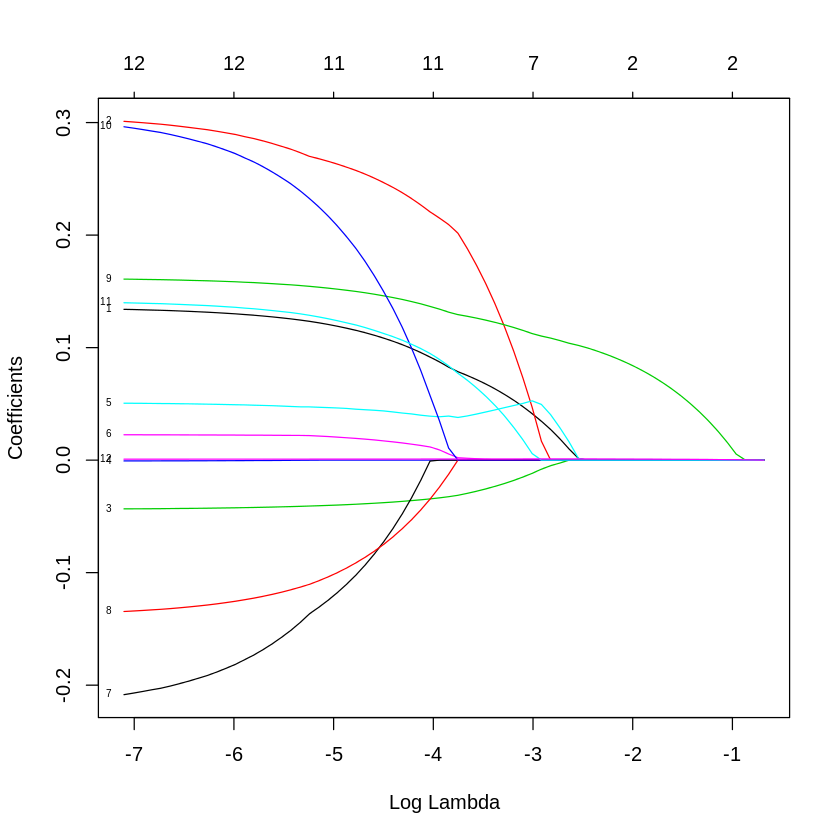

In [26]:
# each curve is a feature (X_i)
# top horizontal axis: number of non-zero coefficients at given lambda
# bottom horizontal axis: lambda (default)
# label=TRUE to label feature curves
plot(fit, xvar = "lambda", label = TRUE)

In [27]:
feature_number <- c(1,9)
names(train[,-1])[feature_number]

[1] "Malic.acid"      "Color.Intensity"

In [28]:
fit %>% summary

          Length Class     Mode   
a0         70    -none-    numeric
beta      840    dgCMatrix S4     
df         70    -none-    numeric
dim         2    -none-    numeric
lambda     70    -none-    numeric
dev.ratio  70    -none-    numeric
nulldev     1    -none-    numeric
npasses     1    -none-    numeric
jerr        1    -none-    numeric
offset      1    -none-    logical
call        5    -none-    call   
nobs        1    -none-    numeric

In [29]:
# df = number of nonzero coefficient
# %dev = the percent (of null) deviance explained
# lambda:  the value of λ
fit


Call:  glmnet(x = X_train, y = y_train, alpha = 1, standardize = TRUE) 

      Df    %Dev    Lambda
 [1,]  0 0.00000 0.5050000
 [2,]  1 0.06711 0.4601000
 [3,]  1 0.12280 0.4193000
 [4,]  2 0.17980 0.3820000
 [5,]  2 0.23830 0.3481000
 [6,]  2 0.28700 0.3172000
 [7,]  2 0.32730 0.2890000
 [8,]  2 0.36080 0.2633000
 [9,]  2 0.38860 0.2399000
[10,]  2 0.41170 0.2186000
[11,]  2 0.43090 0.1992000
[12,]  2 0.44680 0.1815000
[13,]  2 0.46000 0.1654000
[14,]  2 0.47100 0.1507000
[15,]  2 0.48010 0.1373000
[16,]  2 0.48770 0.1251000
[17,]  2 0.49400 0.1140000
[18,]  2 0.49920 0.1039000
[19,]  2 0.50350 0.0946300
[20,]  2 0.50710 0.0862200
[21,]  4 0.51060 0.0785600
[22,]  4 0.51670 0.0715800
[23,]  5 0.52330 0.0652200
[24,]  5 0.52880 0.0594300
[25,]  6 0.53410 0.0541500
[26,]  7 0.53960 0.0493400
[27,]  7 0.54470 0.0449600
[28,]  7 0.54890 0.0409600
[29,]  7 0.55230 0.0373200
[30,]  8 0.55520 0.0340100
[31,]  8 0.55760 0.0309900
[32,]  8 0.55960 0.0282300
[33,]  8 0.56130 0.0257300
[34,]  8

In [30]:
# feature selection
# specify lambda with s (see fit above)
# this will return the "best" features
coef(fit, s=0.3)      # lambda = 0.3 returns 2 "best" features

13 x 1 sparse Matrix of class "dgCMatrix"
                                1
(Intercept)          1.241409e+01
Malic.acid           .           
As                   .           
Alcalinity.in.ash    .           
Magnesium            .           
Total.phenols        .           
Flavonoids           .           
Nonflavonoid.phenols .           
Proanthocyanidins    .           
Color.Intensity      3.151348e-02
Hue                  .           
OD280.OD315          .           
Proline              5.776263e-04

In [31]:
# predict. can specify (multiple) lambdas with s=
predict(fit, X_test, s=c(0.5, 0.3)) %>% head

1,2
13.00488,12.97478
13.01378,13.32126
13.01354,13.31102
13.01354,13.34883
13.01116,13.27479
13.00965,13.16004


### cross validation in glmnet

In [32]:
# more parameters: type.measure, nfolds
cvfit <- cv.glmnet(X_train, y_train)

In [ ]:
?cv.glmnet

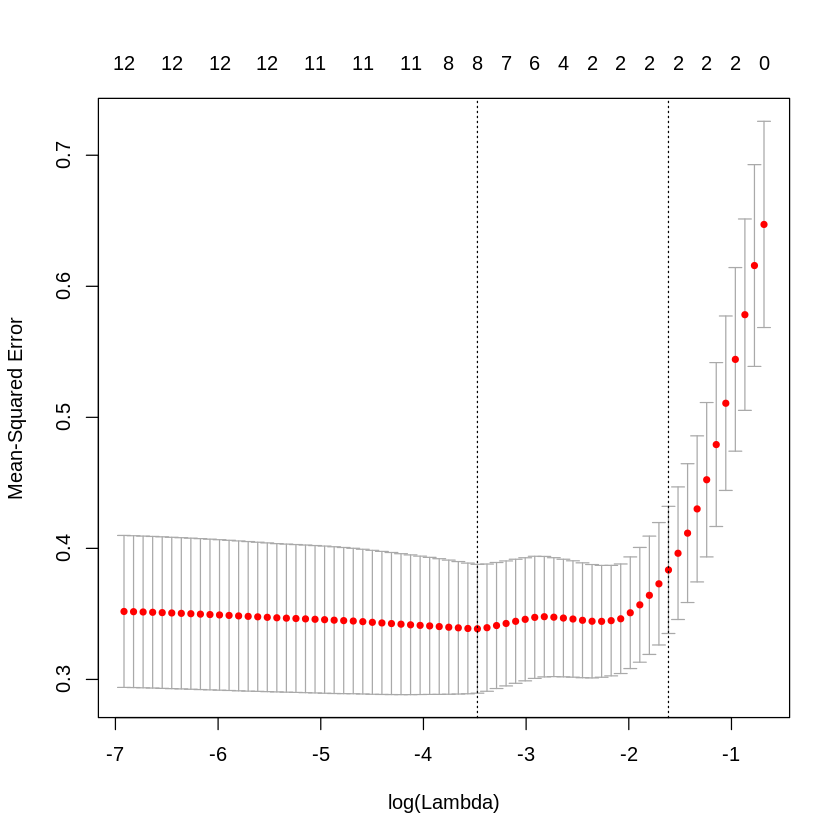

In [34]:
# again, features on top axis, and lambda on bottom axis
# MSE is shown, with standard deviation curves
# 2 vertical lines: lamnda.min and lamnbda.lse (see next)
plot(cvfit)

In [35]:
# extract lambda with minimum mean CV error
# this is one of the vertical lines in the plot above
cvfit$lambda.min

[1] 0.03098612

In [36]:
# extract lambda from regularized model within 1 s.d. of lambda.min 
# this is the other vertical line in plot above
# 1se = "one s-e" not "L s-e"
cvfit$lambda.1se

[1] 0.1991811

In [37]:
# 2 predictors seem to suffice
# compare these coefficients to lm() above
coef(cvfit, s = "lambda.1se")

13 x 1 sparse Matrix of class "dgCMatrix"
                                1
(Intercept)          12.065940835
Malic.acid            .          
As                    .          
Alcalinity.in.ash     .          
Magnesium             .          
Total.phenols         .          
Flavonoids            .          
Nonflavonoid.phenols  .          
Proanthocyanidins     .          
Color.Intensity       0.063645082
Hue                   .          
OD280.OD315           .          
Proline               0.000822241

In [38]:
predict(cvfit, X_test, s="lambda.1se") %>% head

1
12.94523
13.45215
13.43663
13.51301
13.41513
13.21609


### glmnet details

`cv.glmnet` can be parallelized. Search "doMC" here: https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html

You can also specify the penalty factors. Search "penalty factors" in above link.

*Copyright &copy; 2016 The Data Incubator.  All rights reserved.*